In [2]:
import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from collections import OrderedDict, namedtuple

In [35]:
cuda = False
w = "../weights/yolov5m-seg.onnx"
img = cv2.imread("../inference/images/horses.jpg")

In [36]:
providers = (
    ["CUDAExecutionProvider", "CPUExecutionProvider"]
    if cuda
    else ["CPUExecutionProvider"]
)
session = ort.InferenceSession(w, providers=providers)

In [37]:
def letterbox(
    im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32
):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(
        im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )  # add border
    return im, r, (dw, dh)

In [38]:
names = [
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "backpack",
    "umbrella",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "dining table",
    "toilet",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]

In [39]:
colors = {
    name: [random.randint(0, 255) for _ in range(3)] for i, name in enumerate(names)
}

In [40]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255
im.shape

(1, 3, 640, 640)

In [41]:
outname = [i.name for i in session.get_outputs()]
print(outname)

inname = [i.name for i in session.get_inputs()]
print(inname)

['output']
['images']


In [42]:
inp = {inname[0]: im}

In [43]:
# ONNX inference
outputs = session.run(outname, inp)[0]
outputs.shape

(5, 3143)

In [44]:
import torch

outputs = torch.tensor(outputs)

In [45]:
import math

mask_resolution = int(math.sqrt(outputs[:, 7:].shape[-1]))
mask_resolution

56

In [46]:
batch_idxs = outputs[:, 0]
det_bbox = outputs[:, 1:5]
det_conf = outputs[:, 6]
det_cls = outputs[:, 5]
det_mask = outputs[:, 7:].view(-1, mask_resolution, mask_resolution)

det_bbox.shape, det_conf.shape, det_cls.shape, det_mask.shape

(torch.Size([5, 4]), torch.Size([5]), torch.Size([5]), torch.Size([5, 56, 56]))

In [47]:
from torchvision.models.detection.roi_heads import paste_masks_in_image

pred_masks = paste_masks_in_image(det_mask.view(-1, 1, mask_resolution, mask_resolution), det_bbox, (640, 640))
pred_masks[pred_masks < 0.5] = 0
pred_masks[pred_masks > 0.5] = 1

pred_masks = pred_masks.reshape(-1, 640, 640)
pred_masks.shape

torch.Size([5, 640, 640])

In [48]:
det_mask, det_bbox, det_cls, det_conf, pred_masks = (
    det_mask.cpu().numpy(),
    det_bbox.cpu().numpy(),
    det_cls.cpu().numpy(),
    det_conf.cpu().numpy(),
    pred_masks.cpu().numpy()
)
pred_masks = pred_masks.astype(np.bool)

/tmp/ipykernel_30649/1865197859.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_masks = pred_masks.astype(np.bool)


In [49]:
nimg = im[0].copy().transpose(1, 2, 0) * 255
nimg = nimg.astype(np.uint8)
# nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)

In [54]:
pnimg = nimg.copy()
print(pnimg.shape)

(640, 640, 3)


In [55]:
pred_masks.shape

(5, 640, 640)

In [56]:
import cv2

for one_mask, bbox, cls, conf in zip(pred_masks, det_bbox, det_cls, det_conf):
    if conf < 0.25:
        continue

    color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

    pnimg[one_mask] = pnimg[one_mask] * 0.5 + np.array(color, dtype=np.uint8) * 0.5

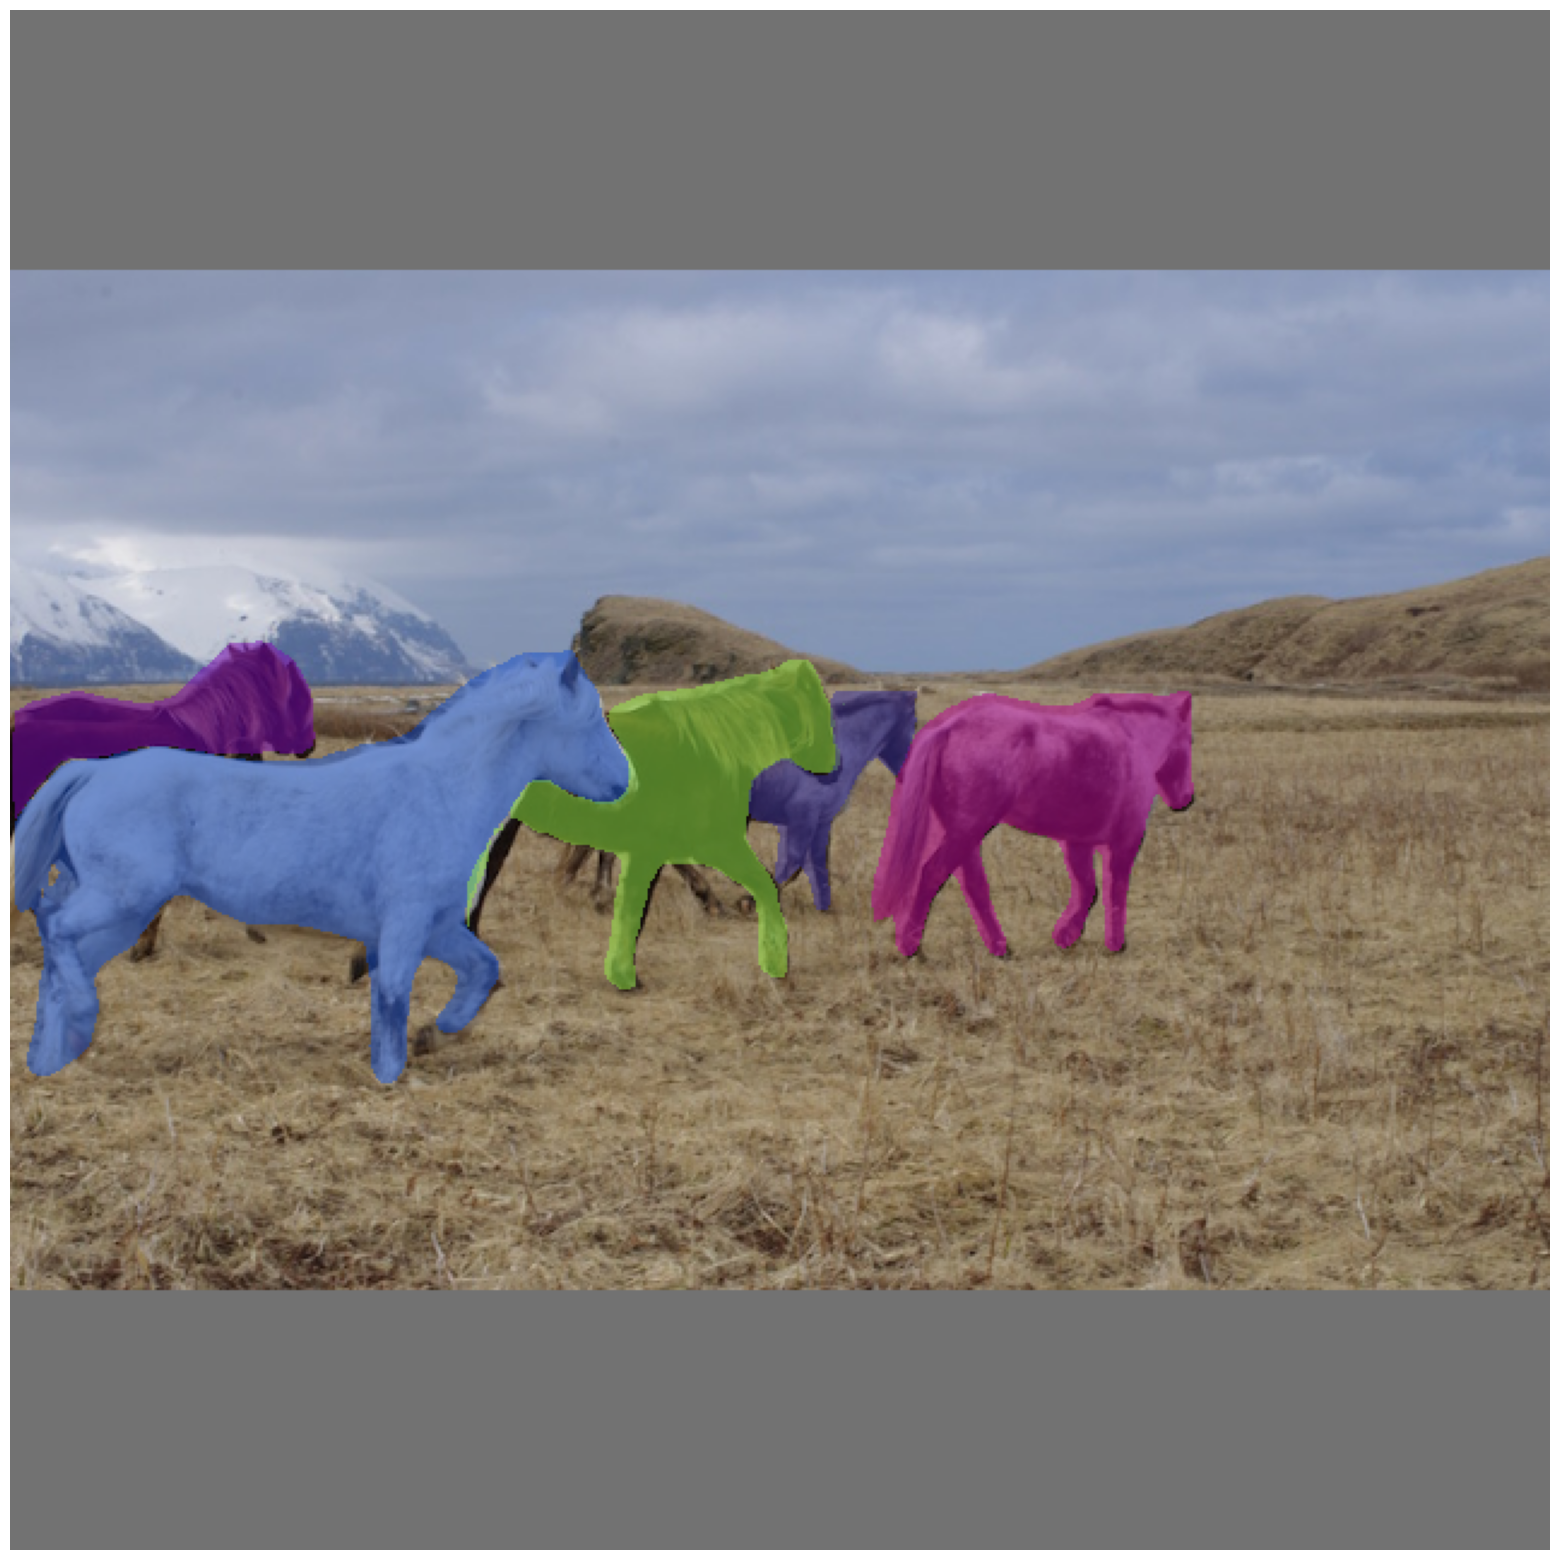

In [57]:
# coco example
%matplotlib inline
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(pnimg)
plt.show()